# Google - Isolated Sign Language Recognition

The goal of this competition is to classify isolated American Sign Language (ASL) signs.

The landmarks were extracted from raw videos with the MediaPipe holistic model and are asked to predict the sign from this data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use("seaborn-colorblind")

In [2]:
# install nb_black for sutoformatting
!pip install nb_black --quiet
%load_ext lab_black

# Data EDA

In [3]:
!ls ../input/asl-signs/ -GFlash --color

total 6.2M
   0 drwxr-xr-x  3 nobody    0 Feb 17 20:30 ./
4.0K drwxr-xr-x  3 root   4.0K Mar  5 09:43 ../
4.0K -rw-r--r--  1 nobody 3.3K Feb 17 20:30 sign_to_prediction_index_map.json
6.2M -rw-r--r--  1 nobody 6.2M Feb 17 20:30 train.csv
   0 drwxr-xr-x 23 nobody    0 Feb 17 20:37 train_landmark_files/


In [4]:
BASE_DIR = "../input/asl-signs/"
train = pd.read_csv(f"{BASE_DIR}/train.csv")

In [5]:
print(train.shape)

# train.csv has the path to each parquet file, the particpant_id, sequence_id and sign
train.head()

(94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


## What signs are we trying to predict?

- 250 Unique signs
- Ranging from 299-415 Example of Each

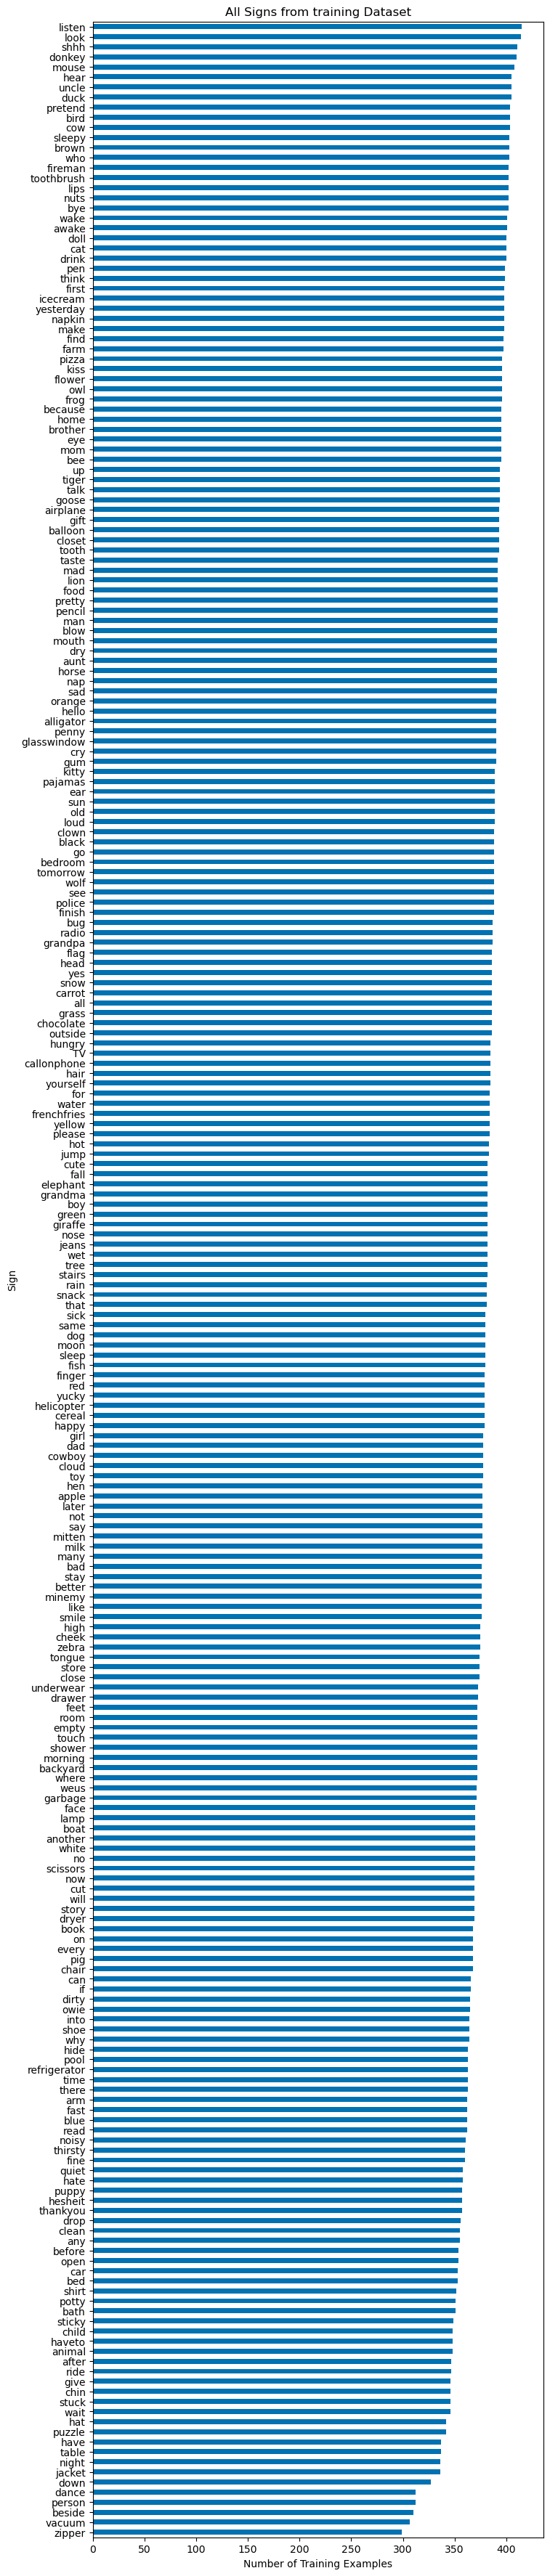

In [6]:
fig, ax = plt.subplots(figsize=(8, 45))
train["sign"].value_counts().sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="All Signs from training Dataset"
)
ax.set_xlabel("Number of Training Examples")
ax.set_ylabel("Sign")
plt.show()

# Parquet Landmark Data

- Each Parquet file is in the path:
    - train_landmark_files/[participant_id]/[sequence_id].parquet
- The parquet's associated sign can be found in train.csv

## Pull an example parquet file data...

We pull an example landmark file for the sign "listen"

In [7]:
example_fn = train.query('sign == "listen"')["path"].values[0]
example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")
example_landmark.head()

,frame,row_id,type,landmark_index,x,y,z
0,35,35-face-0,face,0,0.556969,0.431919,-0.039614
1,35,35-face-1,face,1,0.548688,0.394788,-0.077306
2,35,35-face-2,face,2,0.548806,0.405519,-0.040327
3,35,35-face-3,face,3,0.531849,0.356302,-0.058683
4,35,35-face-4,face,4,0.547539,0.382894,-0.082544


In [8]:
unique_frames = example_landmark["frame"].nunique()
unique_types = example_landmark["type"].nunique()
types_in_video = example_landmark["type"].unique()

print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


## Lets compate for a bunch of parquet files what type of data we have?
- We notice the number of frames is not consistent.
- Almost every file has 4 types of landmarks: ['face' 'left_hand' 'pose' 'right_hand']

In [9]:
listen_files = train.query('sign == "listen"')["path"].values
for i, f in enumerate(listen_files):
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{f}")
    unique_frames = example_landmark["frame"].nunique()
    unique_types = example_landmark["type"].nunique()
    types_in_video = example_landmark["type"].unique()
    print(
        f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
    )
    if i == 20:
        break

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 23 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 28 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 68 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 16 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 8 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 33 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 13 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The 

## Create a metadata for Training Datasets

In [10]:
combined_meta = {}
for i, d in tqdm(train.iterrows(), total=len(train)):
    file_path = d["path"]
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{file_path}")
    meta = example_landmark["type"].value_counts().to_dict()
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )

    for key in xyz_meta.keys():
        new_key = key[0] + "_" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta
    if i >= 1_000:
        break

  0%|          | 0/94477 [00:00<?, ?it/s]

In [11]:
train_with_meta = train.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)

In [12]:
train_with_meta

,path,participant_id,sequence_id,sign,face,pose,left_hand,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,10764.0,759.0,483.0,483.0,23.0,-0.031811,1.294350,0.536739,0.224151,2.147826,0.383747,-2.782624,1.910815,-0.035692
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,5148.0,363.0,231.0,231.0,11.0,-0.017062,1.015931,0.554794,0.329273,2.222732,0.504912,-2.543970,1.627621,-0.040662
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,49140.0,3465.0,2205.0,2205.0,105.0,-0.042923,1.197836,0.438283,0.248094,2.591290,0.457483,-2.838325,1.587503,-0.047699
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,5616.0,396.0,252.0,252.0,12.0,-0.129268,1.156573,0.478509,0.310272,2.294936,0.503025,-3.018237,2.196296,-0.044505
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,8424.0,594.0,378.0,378.0,18.0,0.072425,1.165405,0.488842,0.405282,2.264609,0.545811,-2.970331,1.360011,-0.054411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Evaluation

The evaluation metric for this contest is simple classification accuracy.

Below code is taken from the evaluation page.

In [13]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [14]:
# import tflite_runtime.interpreter as tflite

# def run_model(model_path):
#     interpreter = tflite.Interpreter(model_path)

#     found_signatures = list(interpreter.get_signature_list().keys())

#     if REQUIRED_SIGNATURE not in found_signatures:
#         raise KernelEvalException('Required input signature not found.')

#     prediction_fn = interpreter.get_signature_runner("serving_default")
#     output = prediction_fn(inputs=frames)
#     sign = np.argmax(output["outputs"])